# Demo Notebook with simulated RGCs data

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 
%load_ext memory_profiler

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset
import MEI
import matplotlib as mpl
import pandas as pd
import pickle 

SyntaxError: invalid syntax (MEI.py, line 468)

# Build the dataloaders

The dataloaders object is a dictionary of 3 dictionaries: train, validation and test. Each of them contains the respective data from all datasets combined that were specified in paths. Here we only provide one dataset. While the responses are normalized, we exclude the input images from normalization. The following config was used in the paper (all arguments not in the config have the default value of the function). 

In [110]:
#Use dataloaders with generated RGC data
from lurz2020.datasets.mouse_loaders import static_loaders

paths = ['D://inception_loop/RGC_sim_data/data/static15032021_oval_RF']

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': 1, 
                  'cuda': True,
                  'normalize': True, 
                  'exclude': "images"}

dataloaders_RGCs = static_loaders(**dataset_config)
dat = FileTreeDataset('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF', "images", "responses")

### Look at the data

In [111]:
tier = 'train'
dataset_name = '15032021_oval_RF'

images, responses = [], []
for x, y in dataloaders_RGCs[tier][dataset_name]:
    images.append(x.squeeze().cpu().data.numpy())
    responses.append(y.squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} RGC neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "15032021_oval_RF" contains the responses of 2304 RGC neurons to 4472 images


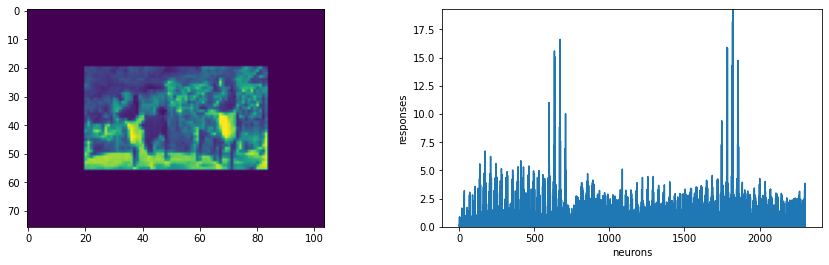

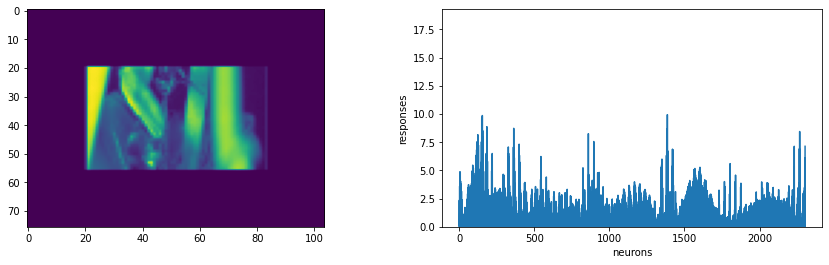

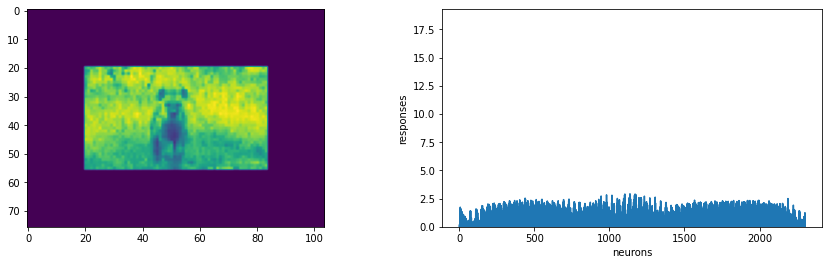

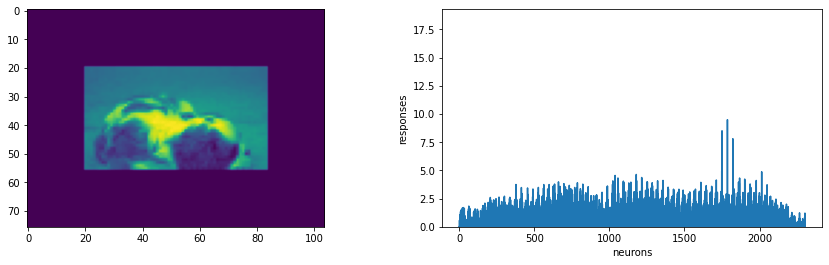

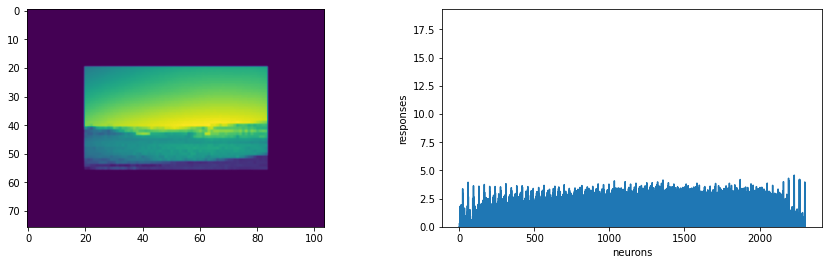

In [5]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i])
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

# MEI generation

In [67]:
neurons_for_MEI_tunned_Fullgaussian = np.load('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_Fullgaussian.npy')

In [68]:
#Load best tunned model instances - se2d_fullgaussian readout
from lurz2020.models.models import se2d_fullgaussian2d

n_seeds = 4

#Build model to load weights of instances 
model_config_tunned = {'init_mu_range': 0.1,
                'init_sigma': 0.64,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 0.99}

models_fullgaussian = []
for n in range(n_seeds):
    model = se2d_fullgaussian2d(**model_config_tunned, dataloaders=dataloaders_RGCs, seed=n)
    model_state = torch.load('D://inception_loop/RGC_sim_data/models/tunned_model_fullgaussian_'+str(n)+'.pth') 
    model.load_state_dict(model_state, strict=False)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    models_fullgaussian.append(model)

In [49]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from theonerig.modelling import *
import random

def grid_MEI_generation_(iter_n, start_sigma, end_sigma, precond):
    
    #Parameters for MEI generation
    
    dataset_name = '27012021'

    MEIParameter = {
    #1000, 1.5, 0.01, 3.0, 0.125, 0.1, 0.1, 0, False, -1, 11.0)
    
    'iter_n' : iter_n,         # int number of iterations to run
    'start_sigma' : start_sigma,   # float starting sigma value
    'end_sigma'   : end_sigma,     # float ending sigma value    
    'start_step_size' : 3.0,  # float starting step size  
    'end_step_size' : 0.125,  # float ending step size   
    'precond' : precond,          # float strength of gradient preconditioning filter falloff 
    'step_gain' : 0.1,      # float scaling of gradient steps
    'jitter' : 0,             # int size of translational jittering
    'blur' : True,            # bool whether to apply bluring or not 
    'norm' :  -1,             # float norm adjustment after step, negative to turn off
    'train_norm' : -1         # float norm adjustment during step, negative to turn off
    }
    
    
    quality_fit_MEIS = []
    neurons_for_tunning_tunned_Fullgaussian = random.sample(list(neurons_for_MEI_tunned_Fullgaussian), 20)
    for neuron in neurons_for_tunning_tunned_Fullgaussian:
        MEI_neuron = MEI.MEI_multi_seed(dataset_name, dat, dataloaders_RGCs, models_fullgaussian, n_seeds, MEIParameter, neuron, track=False)['mei']
        MEI_neuron_std = MEI_neuron/np.max(MEI_neuron.ravel())
        MEI_neuron_scaled = (MEI_neuron_std * 2)-1
        rf = np.load('D://inception_loop/RGC_sim_data/data/static27012021/RFs/'+str(neuron)+'.npy')
        rf_padded = np.pad(rf, pad_width=20, mode='constant', constant_values=0)
        quality_fit_MEI_rf = 1-(np.var(MEI_neuron_scaled-rf_padded)/np.var(MEI_neuron_scaled))
        quality_fit_MEI_gauss = fit_spatial_sta(MEI_neuron_scaled)[1]
        quality_fit_MEIS.append(np.mean([quality_fit_MEI_rf,quality_fit_MEI_gauss]))
    
    mean_quality_fit_MEIS = np.mean(quality_fit_MEIS)
    return mean_quality_fit_MEIS

In [50]:
# Bounded region of parameter space
pbounds={'iter_n' : (500, 1000),
         'start_sigma': (1, 3),
         'end_sigma': (0.005, 0.5),
         'precond' : (0.05,3)}

optimizer_MEIS_ = BayesianOptimization(
    f=grid_MEI_generation_,
    pbounds=pbounds,
    random_state=1,
    verbose = 1,
)

In [51]:
%%time 
%%memit

#Set location to save progress and results
logger = JSONLogger(path="./grid_search_MEI_logs.json")
optimizer_MEIS_.subscribe(Events.OPTIMIZATION_STEP, logger)

#Run optimization to maximize the target (corresponding to the correlation between the model predictions and the real responses for the validation set)
#init_points: number of random exploration points
#n_iter: number of exploitation points

optimizer_MEIS_.maximize(init_points=5, n_iter=5)

Working on neuron_id=1561
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.82it/s]


Working on neuron_id=1293
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.19it/s]


Working on neuron_id=2206
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.39it/s]


Working on neuron_id=473
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.06it/s]


Working on neuron_id=751
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.72it/s]


Working on neuron_id=2197
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.12it/s]


Working on neuron_id=477
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.97it/s]


Working on neuron_id=1726
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.10it/s]


Working on neuron_id=1263
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.48it/s]


Working on neuron_id=45
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.20it/s]


Working on neuron_id=2300
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.17it/s]


Working on neuron_id=183
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.22it/s]


Working on neuron_id=503
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.87it/s]


Working on neuron_id=2016
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.69it/s]


Working on neuron_id=119
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.61it/s]


Working on neuron_id=1003
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.40it/s]


Working on neuron_id=89
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.53it/s]


Working on neuron_id=881
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.75it/s]


Working on neuron_id=1549
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.16it/s]


Working on neuron_id=2039
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.91it/s]


Working on neuron_id=1258
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.02it/s]


Working on neuron_id=1397
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.35it/s]


Working on neuron_id=1281
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.96it/s]


Working on neuron_id=1944
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.20it/s]


Working on neuron_id=1457
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.55it/s]


Working on neuron_id=425
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.70it/s]


Working on neuron_id=1186
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.96it/s]


Working on neuron_id=289
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.47it/s]


Working on neuron_id=99
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.44it/s]


Working on neuron_id=430
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.11it/s]


Working on neuron_id=1626
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.56it/s]


Working on neuron_id=704
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.27it/s]


Working on neuron_id=837
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.72it/s]


Working on neuron_id=2302
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.00it/s]


Working on neuron_id=1431
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.19it/s]


Working on neuron_id=2175
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.19it/s]


Working on neuron_id=1003
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.19it/s]


Working on neuron_id=1374
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.57it/s]


Working on neuron_id=1671
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.81it/s]


Working on neuron_id=1254
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.78it/s]


Working on neuron_id=1937
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.93it/s]


Working on neuron_id=1143
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.73it/s]


Working on neuron_id=1771
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.79it/s]


Working on neuron_id=1983
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.07it/s]


Working on neuron_id=1330
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.08it/s]


Working on neuron_id=1980
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.58it/s]


Working on neuron_id=752
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.34it/s]


Working on neuron_id=1107
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.15it/s]


Working on neuron_id=84
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.46it/s]


Working on neuron_id=921
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.58it/s]


Working on neuron_id=2090
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.18it/s]


Working on neuron_id=2296
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.32it/s]


Working on neuron_id=513
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.97it/s]


Working on neuron_id=1077
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.54it/s]


Working on neuron_id=1807
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.09it/s]


Working on neuron_id=1922
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.50it/s]


Working on neuron_id=1911
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.35it/s]


Working on neuron_id=321
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.79it/s]


Working on neuron_id=2253
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.73it/s]


Working on neuron_id=686
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.28it/s]


Working on neuron_id=2191
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.40it/s]


Working on neuron_id=1935
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.97it/s]


Working on neuron_id=873
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.04it/s]


Working on neuron_id=939
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.08it/s]


Working on neuron_id=394
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.79it/s]


Working on neuron_id=181
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.51it/s]


Working on neuron_id=1585
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.07it/s]


Working on neuron_id=2206
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.75it/s]


Working on neuron_id=1588
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.85it/s]


Working on neuron_id=257
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.88it/s]


Working on neuron_id=1125
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.42it/s]


Working on neuron_id=188
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.66it/s]


Working on neuron_id=1337
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.47it/s]


Working on neuron_id=473
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.54it/s]


Working on neuron_id=55
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.85it/s]


Working on neuron_id=974
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.83it/s]


Working on neuron_id=1397
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.94it/s]


Working on neuron_id=1357
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.06it/s]


Working on neuron_id=369
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.22it/s]


Working on neuron_id=123
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.13it/s]


Working on neuron_id=2089
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.20it/s]


Working on neuron_id=2130
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.79it/s]


Working on neuron_id=125
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.82it/s]


Working on neuron_id=1221
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.32it/s]


Working on neuron_id=1985
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.62it/s]


Working on neuron_id=1091
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.99it/s]


Working on neuron_id=1842
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.74it/s]


Working on neuron_id=919
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.79it/s]


Working on neuron_id=1661
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.76it/s]


Working on neuron_id=761
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.17it/s]


Working on neuron_id=99
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.04it/s]


Working on neuron_id=1027
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.50it/s]


Working on neuron_id=22
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.77it/s]


Working on neuron_id=220
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.30it/s]


Working on neuron_id=331
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.71it/s]


Working on neuron_id=2067
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.38it/s]


Working on neuron_id=1789
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.96it/s]


Working on neuron_id=90
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.97it/s]


Working on neuron_id=644
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.95it/s]


Working on neuron_id=1331
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.83it/s]


Working on neuron_id=969
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.52it/s]


Working on neuron_id=2119
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.25it/s]


Working on neuron_id=864
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.81it/s]


Working on neuron_id=491
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.84it/s]


Working on neuron_id=117
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.67it/s]


Working on neuron_id=1114
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.47it/s]


Working on neuron_id=1041
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.52it/s]


Working on neuron_id=1169
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.10it/s]


Working on neuron_id=437
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.10it/s]


Working on neuron_id=1221
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.71it/s]


Working on neuron_id=1219
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.61it/s]


Working on neuron_id=1509
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.56it/s]


Working on neuron_id=1717
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.00it/s]


Working on neuron_id=1254
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.34it/s]


Working on neuron_id=2219
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.29it/s]


Working on neuron_id=2048
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.53it/s]


Working on neuron_id=1872
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.45it/s]


Working on neuron_id=315
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.29it/s]


Working on neuron_id=2159
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.84it/s]


Working on neuron_id=1671
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.73it/s]


Working on neuron_id=895
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.47it/s]


Working on neuron_id=1409
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.95it/s]


Working on neuron_id=2196
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.66it/s]


Working on neuron_id=765
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.44it/s]


Working on neuron_id=1003
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.39it/s]


Working on neuron_id=1435
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.58it/s]


Working on neuron_id=837
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.49it/s]


Working on neuron_id=1720
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.16it/s]


Working on neuron_id=1009
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.50it/s]


Working on neuron_id=1836
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.17it/s]


Working on neuron_id=1113
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.75it/s]


Working on neuron_id=31
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.57it/s]


Working on neuron_id=1357
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.72it/s]


Working on neuron_id=1955
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.11it/s]


Working on neuron_id=1043
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.06it/s]


Working on neuron_id=55
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.03it/s]


Working on neuron_id=1219
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.67it/s]


Working on neuron_id=2149
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.83it/s]


Working on neuron_id=2011
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.92it/s]


Working on neuron_id=2189
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.17it/s]


Working on neuron_id=421
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.15it/s]


Working on neuron_id=169
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.10it/s]


Working on neuron_id=2192
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.68it/s]


Working on neuron_id=2177
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.49it/s]


Working on neuron_id=1097
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.26it/s]


Working on neuron_id=1530
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.22it/s]


Working on neuron_id=1149
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.43it/s]


Working on neuron_id=2115
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.11it/s]


Working on neuron_id=919
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.93it/s]


Working on neuron_id=1613
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.79it/s]


Working on neuron_id=60
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.97it/s]


Working on neuron_id=2013
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.19it/s]


Working on neuron_id=170
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.48it/s]


Working on neuron_id=58
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.89it/s]


Working on neuron_id=1195
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.41it/s]


Working on neuron_id=821
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.99it/s]


Working on neuron_id=2180
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.91it/s]


Working on neuron_id=1495
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.95it/s]


Working on neuron_id=995
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.46it/s]


Working on neuron_id=2023
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.22it/s]


Working on neuron_id=2079
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.20it/s]


Working on neuron_id=1057
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.68it/s]


Working on neuron_id=561
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.95it/s]


Working on neuron_id=1183
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.77it/s]


Working on neuron_id=597
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.40it/s]


Working on neuron_id=1039
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.18it/s]


Working on neuron_id=1195
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.99it/s]


Working on neuron_id=2048
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.90it/s]


Working on neuron_id=865
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.80it/s]


Working on neuron_id=1002
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.14it/s]


Working on neuron_id=1220
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.56it/s]


Working on neuron_id=322
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.96it/s]


Working on neuron_id=81
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.15it/s]


Working on neuron_id=1911
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.75it/s]


Working on neuron_id=417
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.76it/s]


Working on neuron_id=1027
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.94it/s]


Working on neuron_id=1647
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.20it/s]


Working on neuron_id=723
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.83it/s]


Working on neuron_id=2248
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.96it/s]


Working on neuron_id=881
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.82it/s]


Working on neuron_id=769
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.48it/s]


Working on neuron_id=1080
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.81it/s]


Working on neuron_id=605
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.21it/s]


Working on neuron_id=1428
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.10it/s]


Working on neuron_id=2237
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.27it/s]


Working on neuron_id=288
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.59it/s]


Working on neuron_id=307
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.43it/s]


Working on neuron_id=2075
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.71it/s]


Working on neuron_id=1063
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.68it/s]


Working on neuron_id=1101
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.40it/s]


Working on neuron_id=729
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.03it/s]


Working on neuron_id=1437
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.02it/s]


Working on neuron_id=535
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.42it/s]


Working on neuron_id=231
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.73it/s]


Working on neuron_id=1107
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.83it/s]


Working on neuron_id=2238
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.21it/s]


Working on neuron_id=707
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.91it/s]


Working on neuron_id=1910
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.76it/s]


Working on neuron_id=1476
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.91it/s]


Working on neuron_id=893
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.77it/s]


peak memory: 2242.95 MiB, increment: 0.62 MiB
Wall time: 3h 56min 7s


In [52]:
optimizer_MEIS_.res

[{'target': 0.5137785047183565,
  'params': {'end_sigma': 0.21142589232777415,
   'iter_n': 860.1622467210791,
   'precond': 0.05033740571116742,
   'start_sigma': 1.6046651452636795}},
 {'target': 0.36511056007663956,
  'params': {'end_sigma': 0.07764416595447096,
   'iter_n': 546.1692973843989,
   'precond': 0.5994676235641292,
   'start_sigma': 1.6911214540860955}},
 {'target': 0.20107297047284595,
  'params': {'end_sigma': 0.20139989974418163,
   'iter_n': 769.4083670016785,
   'precond': 1.2866238174897198,
   'start_sigma': 2.370439000793519}},
 {'target': 0.5245631783881641,
  'params': {'end_sigma': 0.10620386361710113,
   'iter_n': 939.0587181954727,
   'precond': 0.13079339993388217,
   'start_sigma': 2.3409350203568042}},
 {'target': 0.3255205156429488,
  'params': {'end_sigma': 0.21156587717172784,
   'iter_n': 779.3449142228758,
   'precond': 0.46414146885593965,
   'start_sigma': 1.3962029781697576}},
 {'target': 0.22265764558216122,
  'params': {'end_sigma': 0.2286017744

In [53]:
optimizer_MEIS_.max

{'target': 0.5245631783881641,
 'params': {'end_sigma': 0.10620386361710113,
  'iter_n': 939.0587181954727,
  'precond': 0.13079339993388217,
  'start_sigma': 2.3409350203568042}}

In [60]:
target = []
end_sigma = []
iter_n = []
precond = []
start_sigma = []
for i in range(len(optimizer_MEIS_.res)):
    target.append(optimizer_MEIS_.res[i]['target'])
    end_sigma.append(optimizer_MEIS_.res[i]['params']['end_sigma'])
    iter_n.append(int(optimizer_MEIS_.res[i]['params']['iter_n']))
    precond.append(int(optimizer_MEIS_.res[i]['params']['precond']))
    start_sigma.append(optimizer_MEIS_.res[i]['params']['start_sigma'])

In [65]:
dict_plot = { 'iter_n': iter_n,
             'precond': precond,
              'end_sigma': end_sigma,
              'start_sigma': start_sigma,
              'target': target
            }

In [66]:
#Plot evolution of bayesian grid search
import plotly.express as px
df_gs_results = pd.DataFrame(data=dict_plot)
fig = px.parallel_coordinates(df_gs_results, color='target', color_continuous_scale = 'portland', title= f"Bayes Hyperparameters Grid Search - MEI parameters n iter={len(optimizer_MEIS_.res)}")
fig.show()

-------------------------------

In [69]:
dataset_name = '27012021'

MEIParameter = {
    #1000, 1.5, 0.01, 3.0, 0.125, 0.1, 0.1, 0, False, -1, 11.0)
    
    'iter_n' : 1000,         # int number of iterations to run
    'start_sigma' : 2.34,   # float starting sigma value
    'end_sigma'   : 0.106,     # float ending sigma value    
    'start_step_size' : 3.0,  # float starting step size  
    'end_step_size' : 0.125,  # float ending step size   
    'precond' : 0.13,          # float strength of gradient preconditioning filter falloff 
    'step_gain' : 0.1,      # float scaling of gradient steps
    'jitter' : 0,             # int size of translational jittering
    'blur' : True,            # bool whether to apply bluring or not 
    'norm' :  -1,             # float norm adjustment after step, negative to turn off
    'train_norm' : -1         # float norm adjustment during step, negative to turn off
    }
MEIS_tunned = {}

In [106]:
#Generate MEI for one target unit
TargetUnit = 1023
MEIS_tunned[str(TargetUnit)] = MEI.MEI_multi_seed(dataset_name, dat, dataloaders_RGCs, models_fullgaussian, 4, MEIParameter, TargetUnit, track=False)

Working on neuron_id=1023
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.27it/s]


In [109]:
file = open('D://inception_loop/RGC_sim_data/results/MEIS_tunned.txt','w')
file.write(cPickle.dumps(self.__dict__))
file.close()

MEIS_tunned

{'453': {'neuron_id': 453,
  'n_seeds': 4,
  'mei': array([[124.63185935, 124.63400501, 124.63828635, ..., 127.36493683,
          127.36623168, 127.36688182],
         [124.62522986, 124.6273837 , 124.63167139, ..., 127.3653854 ,
          127.36669295, 127.36735399],
         [124.61156137, 124.6137261 , 124.61804194, ..., 127.36598106,
          127.36730859, 127.36798416],
         ...,
         [125.49244684, 125.49581561, 125.50254316, ..., 127.46694249,
          127.46787231, 127.46834448],
         [125.50661202, 125.50995355, 125.5166348 , ..., 127.4669552 ,
          127.46788684, 127.46835719],
         [125.51385079, 125.51718233, 125.52383906, ..., 127.46714952,
          127.46809568, 127.46856422]]),
  'activation': 0.77586573,
  'monotonic': True,
  'max_activation': 0.77586573,
  'max_contrast': 7.717568106850007,
  'sat_contrast': 7.717568106850007,
  'img_mean': 125.6058691669711,
  'lim_contrast': 11.875791616479233},
 '788': {'neuron_id': 788,
  'n_seeds': 4,
  'm

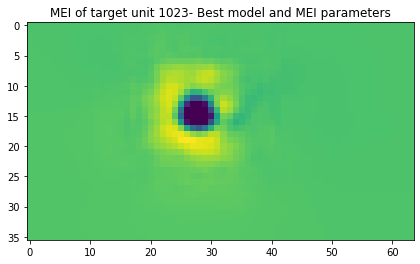

In [107]:
#Plot generated MEI
TargetUnit = 1023
fig, axs = plt.subplots(figsize=(20,4))
axs.imshow(MEIS_tunned[str(TargetUnit)]['mei'][20:56,20:84])
axs.set_title('MEI of target unit '+str(TargetUnit)+'- Best model and MEI parameters')
plt.savefig("D://inception_loop/RGC_sim_data/results/MEI_target_unit_"+str(TargetUnit)+"-Best model_and_MEI.png")

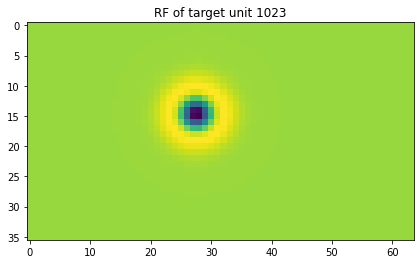

In [108]:
TargetUnit=1023
rf = np.load('D://inception_loop/RGC_sim_data/data/static27012021/RFs/'+str(TargetUnit)+'.npy')
fig, axs = plt.subplots(figsize=(20,4))
axs.imshow(rf)
axs.set_title("RF of target unit "+str(TargetUnit))
plt.savefig("D://inception_loop/RGC_sim_data/results/RF_target_unit_"+str(TargetUnit)+".png")

In [93]:
neurons_for_MEI_tunned_Fullgaussian[250:700]

array([ 389,  391,  392,  393,  394,  395,  397,  398,  399,  401,  402,
        403,  405,  407,  409,  411,  412,  413,  415,  417,  418,  419,
        421,  423,  425,  427,  428,  429,  430,  431,  432,  434,  435,
        437,  439,  441,  443,  445,  447,  448,  449,  451,  452,  453,
        454,  455,  457,  459,  461,  463,  465,  466,  467,  468,  469,
        470,  471,  472,  473,  475,  477,  479,  481,  482,  483,  485,
        487,  488,  489,  491,  493,  495,  497,  499,  501,  502,  503,
        504,  505,  506,  507,  508,  509,  511,  513,  515,  517,  519,
        521,  523,  525,  527,  528,  531,  533,  534,  535,  536,  537,
        538,  540,  541,  542,  543,  544,  545,  547,  549,  551,  553,
        555,  557,  559,  561,  563,  565,  569,  571,  573,  574,  575,
        576,  577,  578,  579,  580,  581,  583,  585,  597,  598,  599,
        604,  605,  607,  608,  609,  610,  611,  613,  614,  615,  616,
        617,  618,  619,  620,  621,  633,  635,  6